In [173]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from matplotlib.colors import LogNorm
from scipy.signal import stft
import zarr
from statsmodels.sandbox.distributions.try_pot import mean_residual_life

plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

In [175]:
shot_data = requests.get("https://mastapp.site/json/shots/30421").json()
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)

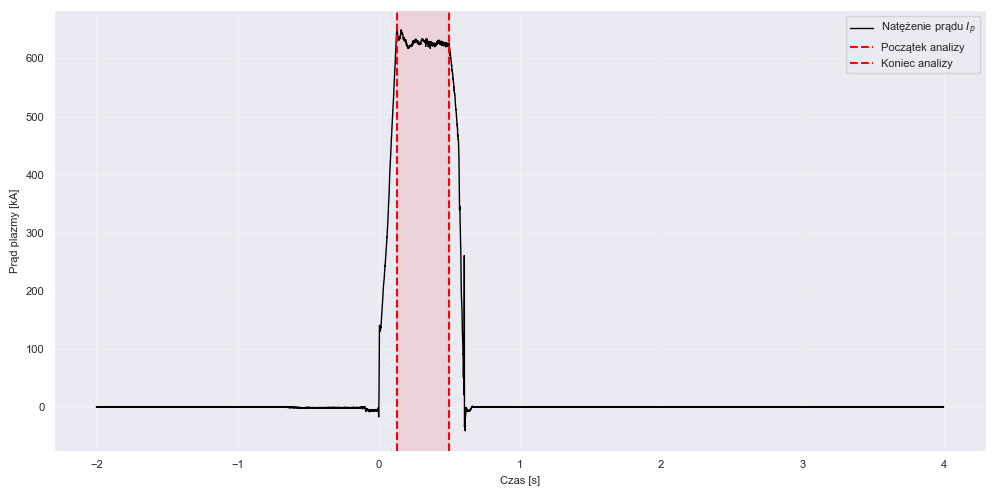

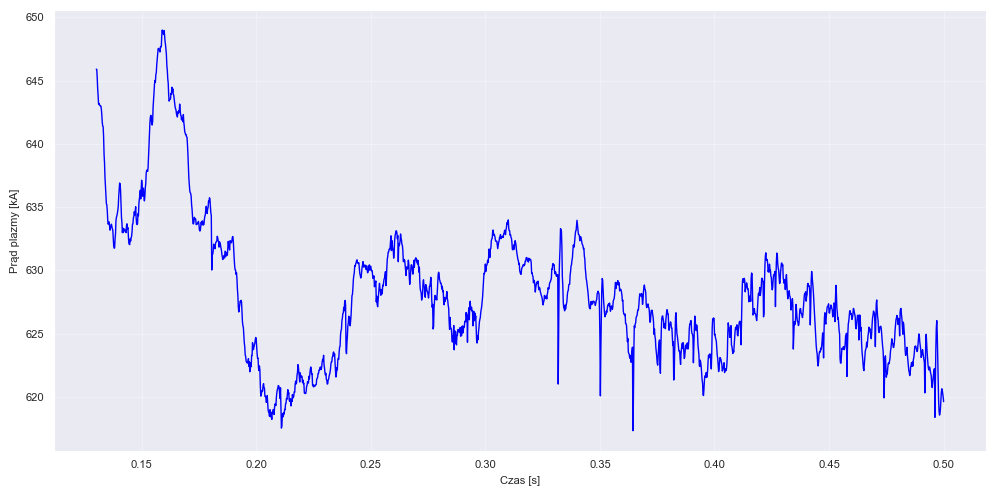

In [176]:
dataset = xr.open_zarr(shot_url, group='amc', storage_options={'ssl': False})
# dataset = dataset.isel(time=(dataset.time > 0) & (dataset.time < .35))
dataset = dataset.isel()
ts_full = dataset['plasma_current'].to_series()

start_cut = 0.13
end_cut = 0.5
mast_data = ts_full[(ts_full.index > start_cut) & (ts_full.index < end_cut)]

# RYSUNEK 1: Cały przebieg z zaznaczonym wycinkiem
plt.figure(figsize=(10, 5))
plt.plot(dataset['time'], dataset['plasma_current'], label='Natężenie prądu $I_p$', color='black', linewidth=1)

plt.axvline(x=start_cut, color='red', linestyle='--', label='Początek analizy')
plt.axvline(x=end_cut, color='red', linestyle='--', label='Koniec analizy')
plt.axvspan(start_cut, end_cut, color='red', alpha=0.1)

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure1.pdf")
plt.show()

# RYSUNEK 2: Tylko ten wycinek (mast_data)
plt.figure(figsize=(10, 5))
plt.plot(mast_data, color='blue', linewidth=1)
plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure2.pdf")
plt.show()


### ACF, ACVF, PACF

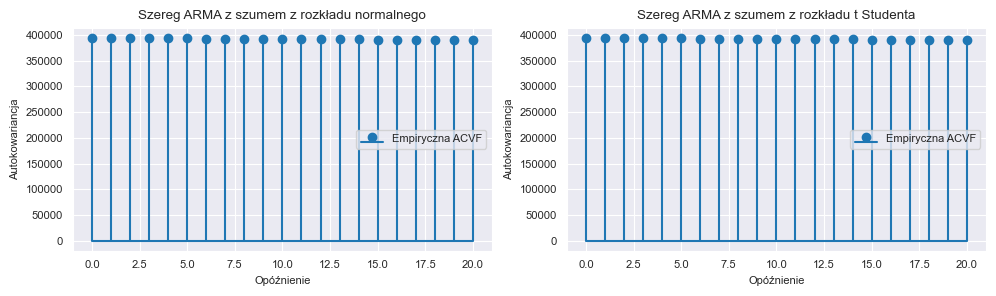

In [177]:
# Porównanie teoretycznej i empirycznej autokowariancji

h_max = 20

plt.figure(figsize=(10, 3))

# Szum z rozkładu normalnego

plt.subplot(1, 2, 1)

# autokow_teor = arma_acovf(ar_coef, ma_coef, nobs = h_max, sigma2=sigma**2)
autokow_emp = acovf(mast_data, demean=False, fft=False, nlag=h_max)

plt.stem(autokow_emp, basefmt='', label='Empiryczna ACVF')
# plt.plot(autokow_teor, '-', label='Teoretyczna ACVF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokowariancja')
plt.title('Szereg ARMA z szumem z rozkładu normalnego')
plt.legend()

plt.subplot(1, 2, 2)

# Szum z rozkładu t Studenta

# autokow_teor_t = arma_acovf(ar_coef, ma_coef, nobs = h_max, sigma2 = (tau)**2*(degrees/(degrees-2)))
autokow_emp_t = acovf(mast_data, demean=False, fft=False, nlag=h_max)

plt.stem(autokow_emp_t, basefmt='', label='Empiryczna ACVF')
# plt.plot(autokow_teor_t, '-', label='Teoretyczna ACVF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokowariancja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()

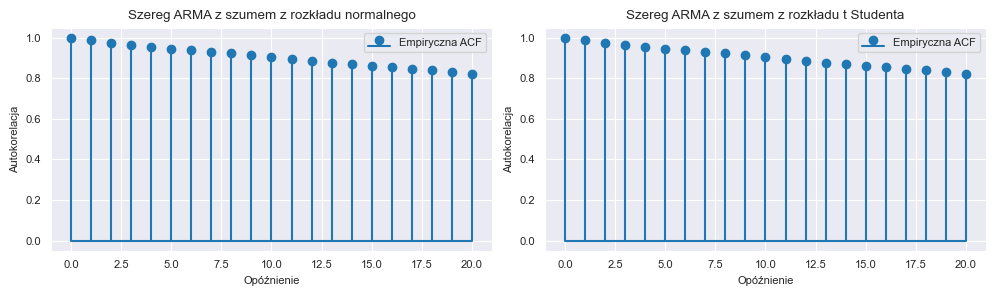

In [178]:
# Porównanie teoretycznej i empirycznej autokorelacji

h_max = 20

plt.figure(figsize=(10, 3))

# Szum z rozkładu normalnego

plt.subplot(1, 2, 1)

# acf_teor = arma_acf(ar_coef, ma_coef, lags=h_max)
acf_emp = acf(mast_data, fft=True, nlags=h_max)

plt.stem(acf_emp, basefmt='', label='Empiryczna ACF')
# plt.plot(acf_teor, '-', label='Teoretyczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu normalnego')
plt.legend()

# Szum z rozkładu t-Studenta

plt.subplot(1, 2, 2)

# acf_teor_t = arma_acf(ar_coef, ma_coef, lags=h_max)
acf_emp_t = acf(mast_data, fft=False, nlags=h_max)

plt.stem(acf_emp_t, basefmt='', label='Empiryczna ACF')
# plt.plot(acf_teor_t, '-', label='Teoretyczna ACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()


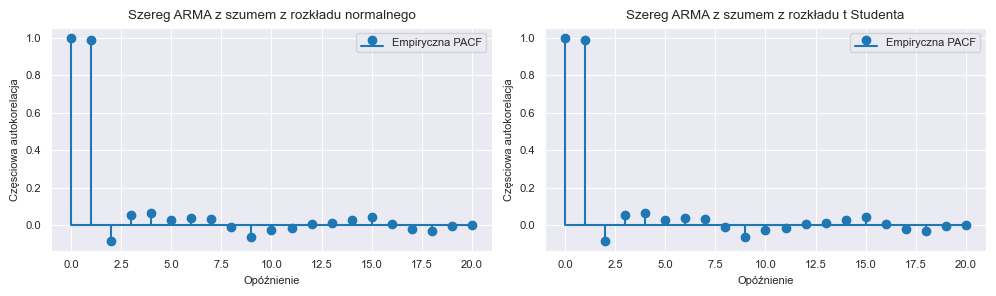

In [179]:
# Porównanie teoretycznej i empirycznej fun. częściowej autokorelacji

plt.figure(figsize=(10, 3))

# Szum z rozkładu normalnego

plt.subplot(1, 2, 1)

# acf_teor = arma_pacf(ar_coef, ma_coef, lags=h_max)
acf_emp = pacf(mast_data, nlags=h_max, method='yw')

plt.stem(acf_emp, basefmt='', label='Empiryczna PACF')
# plt.plot(acf_teor, '-', label='Teoretyczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu normalnego')
plt.legend()

# Szum z rozkładu t-Studenta

plt.subplot(1, 2, 2)

# acf_teor_t = arma_pacf(ar_coef, ma_coef, lags=h_max)
acf_emp_t = pacf(mast_data, nlags=h_max, method='yw')

plt.stem(acf_emp_t, basefmt='', label='Empiryczna PACF')
# plt.plot(acf_teor_t, '-', label='Teoretyczna PACF')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa autokorelacja')
plt.title('Szereg ARMA z szumem z rozkładu t Studenta')
plt.legend()

plt.tight_layout()
plt.show()


### sezonowos czyli pulsowanie cewki plazmowej??

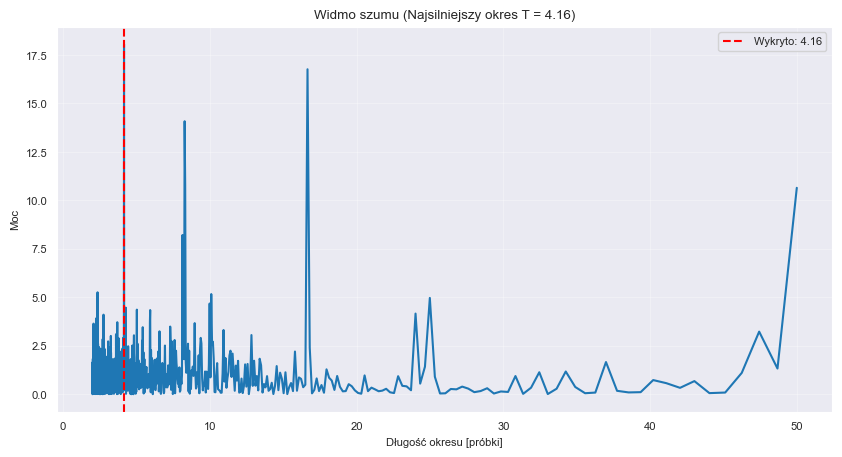

In [180]:
from scipy.signal import periodogram

# Bierzemy różnicę (żeby usunąć wolny trend i zobaczyć tylko szybkie tętnienia)
data_diff = mast_data.diff().dropna()

# Obliczamy periodogram dla danych BEZ trendu
fs = 1.0 # Zakładamy próbkowanie 1 (wynik w cyklach na próbkę)
freqs, power = periodogram(data_diff.values, fs=fs)

# Szukamy piku, ale TYLKO w zakresie krótkich okresów (tzw. wysokie częstotliwości)
# Interesują nas okresy od 2 do 50 próbek (tam żyją tętnienia zasilania)
# Przeliczamy okresy na indeksy tablicy (trochę matematyki indeksowej)
valid_mask = (freqs > 1/50) & (freqs < 1/2) # Zakres f: od 0.02 do 0.5
freqs_zoom = freqs[valid_mask]
power_zoom = power[valid_mask]

# Znajdujemy najsilniejszy pik w tym zakresie
max_idx = np.argmax(power_zoom)
dominant_freq = freqs_zoom[max_idx]
exact_period = 1 / dominant_freq

plt.figure(figsize=(10, 5))
plt.plot(1/freqs_zoom, power_zoom)
plt.title(f"Widmo szumu (Najsilniejszy okres T = {exact_period:.2f})")
plt.xlabel("Długość okresu [próbki]")
plt.ylabel("Moc")
plt.axvline(x=exact_period, color='r', linestyle='--', label=f'Wykryto: {exact_period:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

period = int(exact_period)

### Dekompozycja szeregu czasowego - przykład 2

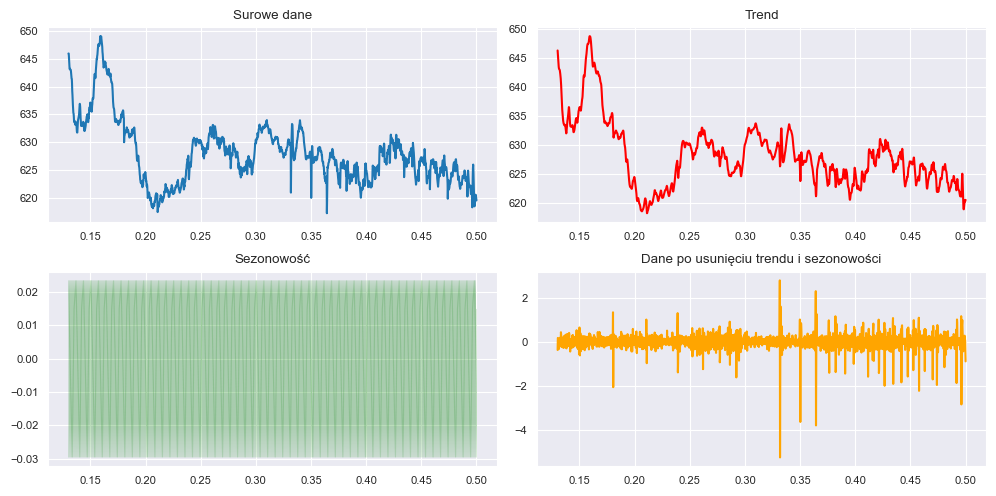

In [181]:
decomposition = seasonal_decompose(mast_data, model='additive', period=period, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [182]:
### Dekompozycja szeregu czasowego - przykład 3

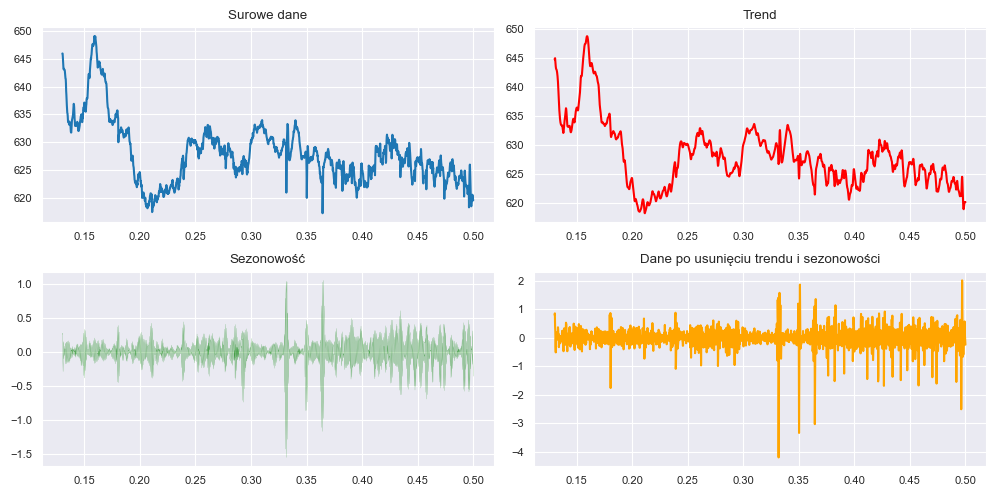

In [183]:
# https://otexts.com/fpp2/stl.html

stl_decomposition = STL(mast_data, period=period).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja szeregu czasowego - przykład 4

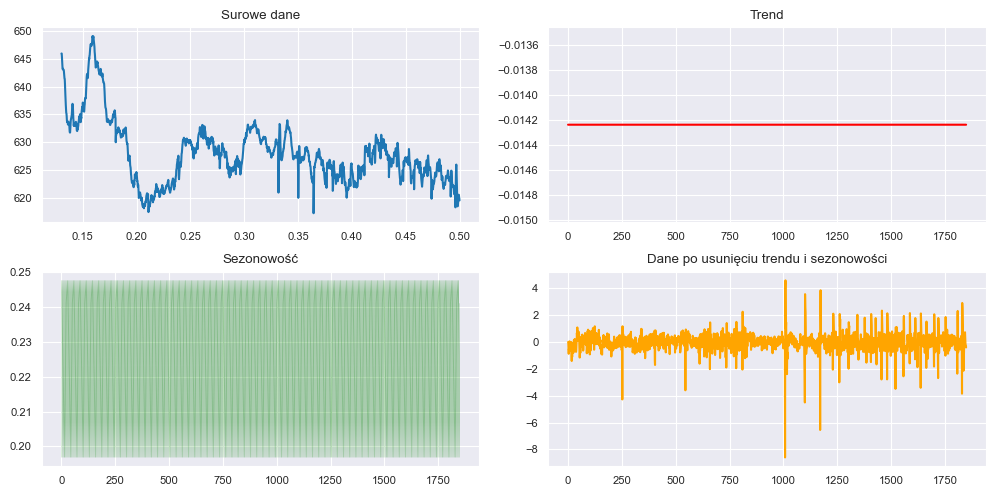

In [184]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(mast_data.values, seasonal_periods=period, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

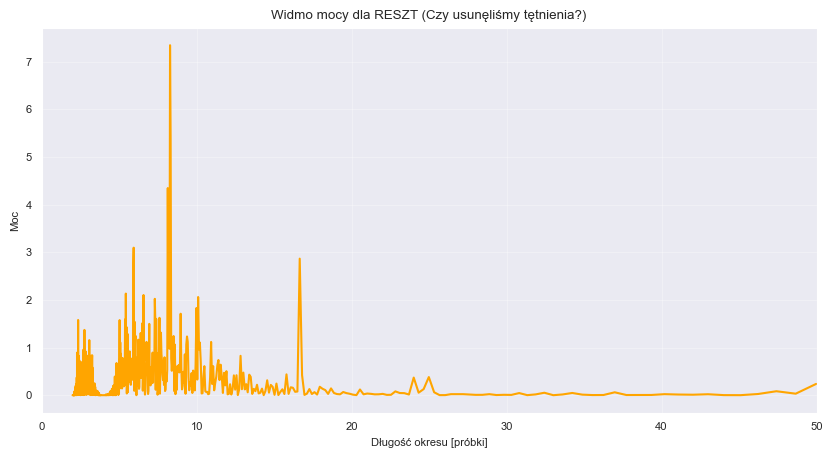

In [185]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

residual_clean = residual_stl

# Obliczamy periodogram dla reszt
fs = 1.0
freqs, power = periodogram(residual_clean.values[1:], fs=fs)

plt.figure(figsize=(10, 5))
plt.plot(1/freqs[valid_mask], power[valid_mask], color='orange')

plt.title("Widmo mocy dla RESZT (Czy usunęliśmy tętnienia?)")
plt.xlabel("Długość okresu [próbki]")
plt.ylabel("Moc")
plt.xlim(0, 50)
plt.grid(True, alpha=0.3)
plt.show()